In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
#TENSORFLOW ONLY USED FOR THE MNIST DATA SET, NOTHING ELSE
print("TensorFlow version:", tf.__version__)


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

TensorFlow version: 2.11.0


In [2]:
"""
when the input z is a vector or Numpy array, Numpy automatically applies the 
function sigmoid elementwise, that is, in vectorized form.
"""
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [3]:
"""
In this code, the list sizes contains the number of neurons in the respective 
layers. So, for example, if we want to create a Network object with 2 neurons 
in the first layer, 3 neurons in the second layer, and 1 neuron in the final 
layer, we'd do this with the code:

net = Network([2, 3, 1])

The biases and weights in the Network object are all initialized randomly, using
the Numpy np.random.randn function to generate Gaussian distributions with mean 
0 and standard deviation 1.

Assumes first layer is an input layer and omits to set any biases for those 
neurons
"""
class Network(object):

  def __init__(self, sizes):
    self.num_layers = len(sizes)
    self.sizes = sizes
    # gives a bias to all neurons except the first layer which are assumed to be
    # input
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    # makes y by x array for the weights, zips all nodes except the last layer
    # with all nodes except the first layer
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

  def feedforward(self, a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(self.biases, self.weights):
      a = sigmoid(np.dot(w, a)+b)
    return a



  def fit(self, training_data, epochs, mini_batch_size, eta, test_data=None):
    """Train the neural network using batch SGD. 'training_data' is a list of
    tuples '(x, y)' representing the training inputs and their labels. If 
    'test_data' is provided then the network will be evaluated against the test
    data after each epoch, with partial progress printed out. Useful for tracking
    progress but slows the function down substantially.
    
    'eta' is learning rate.
    'mini_batch_size' is the size of the batches
    'epochs' is the amount of epochs to run
    
    The code works as follows. In each epoch, it starts by randomly shuffling 
    the training data, and then partitions it into mini-batches of the 
    appropriate size. This is an easy way of sampling randomly from the training
    data. Then for each mini_batch we apply a single step of gradient descent. 
    This is done by the code 'self.update_mini_batch(mini_batch, eta)', which 
    updates the network weights and biases according to a single iteration of 
    gradient descent, using just the training data in mini_batch."""
    if test_data: n_test = len(test_data)
    n = len(training_data)
    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch, eta)
      if test_data:
        print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
      else:
        print("Epoch {0} complete".format(j))

    
  def update_mini_batch(self, mini_batch, eta):
    """Update the network's weights and biases by applying a single step of
    gradient descent using backpropagation to a single mini batch for each call
    to backprop. The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
      # Invokes backpropogation algorithm which is a fast way of computing the 
      # gradient of the cost function
      delta_nabla_b, delta_nabla_w = self.backprop(x, y)
      nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    
    
  def backprop(self, x, y):
    """Return a tuple'(nabla_b, nabla_w)' representing the gradient for the cost
    function C_x. 'nabla_b' and 'nabla_w' are layer by layer lists of numpy 
    arrays, similar to 'self.biases' and 'self.weights'."""
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation)+b
      zs.append(z)
      activation = sigmoid(z)
      activations.append(activation)
    # backward pass
    delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    # Note that the variable l in the loop below is used a little
    # differently to the notation in Chapter 2 of the book.  Here,
    # l = 1 means the last layer of neurons, l = 2 is the
    # second-last layer, and so on.  It's a renumbering of the
    # scheme in the book, used here to take advantage of the fact
    # that Python can use negative indices in lists.
    for l in range(2, self.num_layers):
      z = zs[-l]
      sp = sigmoid_prime(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)



  def evaluate(self, test_data):
    test_results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)


  def cost_derivative(self, output_activations, y):
    """Return the vector of partial derivatives \partial C_x \partial a for the
    output activations."""
    return (output_activations-y)


In [4]:
def load_data():
  # Load and prepare the MNIST dataset.
  mnist = tf.keras.datasets.mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  # Convert the data from integers to floating-point numbers
  x_train, x_test = x_train / 255.0, x_test / 255.0

  return(x_train, x_test, y_train, y_test)


def load_data_wrapper2():
  x_tr, x_ts, y_tr, y_ts = load_data()
  x_tr = [np.reshape(x, (784, 1)) for x in x_train[:]]
  y_tr = [np.argmax(vectorized_result(y)) for y in y_train[:]]
  training_data = list(zip(x_tr, y_tr))
  x_ts = [np.reshape(x, (784, 1)) for x in x_test[:]]
  y_ts = [np.argmax(vectorized_result(y)) for y in y_test[:]]
  test_data = list(zip(x_ts, y_ts))
  return(training_data, test_data)

def load_data_wrapper():
  x_tr, x_ts, y_tr, y_ts = load_data()
  x_tr = [np.reshape(x, (784, 1)) for x in x_train[:]]
  y_tr = [vectorized_result(y) for y in y_train[:]]
  training_data = list(zip(x_tr, y_tr))
  x_ts = [np.reshape(x, (784, 1)) for x in x_test[:]]
  y_ts = [vectorized_result(y) for y in y_test[:]]
  test_data = list(zip(x_ts, y_ts))
  return(training_data, test_data)


def vectorized_result(j):
  """Return a 10-dimensional unit vector with a 1.0 in the jth
  position and zeroes elsewhere.  This is used to convert a digit
  (0...9) into a corresponding desired output from the neural
  network."""
  e = np.zeros((10, 1))
  e[j] = 1.0
  return e

In [5]:
x_train, x_test, y_train, y_test = load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Shape of the image: (28, 28)


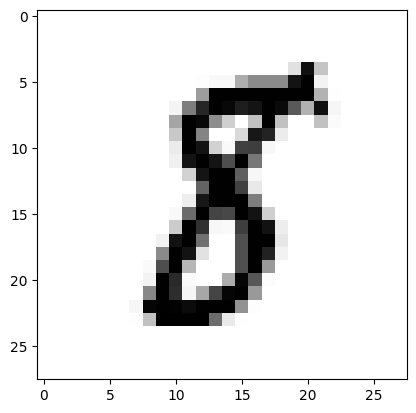

In [7]:
# extract the first image in x_train
idx = 125
img = x_train[idx, :, :] # : means that we include all indices
print("Shape of the image:", img.shape)
plt.imshow(img, cmap="Greys")

In [8]:
print("Shape of y_train:", y_train.shape)
y_train[idx]

Shape of y_train: (60000,)


8

In [9]:
tr_data, ts_data = load_data_wrapper()

In [10]:
tr_data[125]

(array([[0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   ],
        [0.   

In [11]:
net = Network([784, 50, 10])
net.fit(tr_data, 10, 10, 3.0, test_data=ts_data)

Epoch 0: 8271 / 10000
Epoch 1: 9314 / 10000
Epoch 2: 9403 / 10000
Epoch 3: 9464 / 10000
Epoch 4: 9516 / 10000
Epoch 5: 9518 / 10000
Epoch 6: 9525 / 10000
Epoch 7: 9527 / 10000
Epoch 8: 9550 / 10000
Epoch 9: 9554 / 10000


In [12]:
print(net.weights)

[array([[ 0.879,  0.151, -2.478, ..., -0.148,  0.677,  1.367],
       [ 0.547, -1.459,  0.67 , ..., -0.01 ,  1.029,  0.353],
       [-0.405, -1.009,  1.702, ...,  0.945, -0.199,  1.588],
       ...,
       [ 0.085, -0.593,  0.46 , ...,  1.29 , -0.549,  1.912],
       [ 1.272,  0.442,  0.368, ..., -0.722, -0.513,  0.59 ],
       [-0.228,  0.496, -2.584, ...,  0.111,  0.659,  0.191]]), array([[-0.919,  1.983,  0.308, -1.964, -2.353,  0.744, -2.785,  0.702,
         0.183,  0.581, -3.416, -1.435,  0.082,  3.836,  1.157,  0.191,
        -0.681, -4.231, -0.183, -1.884,  1.19 , -1.982,  2.242, -3.268,
         0.775, -1.569, -0.485,  2.816, -2.804, -1.649,  3.005,  2.95 ,
         0.401,  1.146, -1.198,  1.984,  1.067, -2.243,  0.546,  2.418,
        -2.644, -0.288,  0.898, -2.003,  2.174, -3.387,  0.236, -1.75 ,
        -1.017, -2.531],
       [-0.764, -1.468,  0.903, -2.481, -3.297, -2.373, -0.401,  1.474,
         0.447, -2.801, -0.79 , -1.848,  1.675, -1.406, -2.677,  2.335,
         2.0

In [13]:
net.fit(tr_data, 2, 10, 0.5, test_data=ts_data)

Epoch 0: 9576 / 10000
Epoch 1: 9576 / 10000


In [14]:
print(net.evaluate(ts_data))

9576


In [15]:
print(net.weights)

[array([[ 0.879,  0.151, -2.478, ..., -0.148,  0.677,  1.367],
       [ 0.547, -1.459,  0.67 , ..., -0.01 ,  1.029,  0.353],
       [-0.405, -1.009,  1.702, ...,  0.945, -0.199,  1.588],
       ...,
       [ 0.085, -0.593,  0.46 , ...,  1.29 , -0.549,  1.912],
       [ 1.272,  0.442,  0.368, ..., -0.722, -0.513,  0.59 ],
       [-0.228,  0.496, -2.584, ...,  0.111,  0.659,  0.191]]), array([[-0.894,  1.909,  0.373, -1.977, -2.366,  0.786, -2.839,  0.774,
         0.287,  0.474, -3.459, -1.493,  0.04 ,  3.796,  1.13 ,  0.18 ,
        -0.681, -4.29 , -0.13 , -1.832,  1.045, -2.019,  2.232, -3.315,
         0.771, -1.56 , -0.556,  2.808, -2.843, -1.633,  2.965,  2.943,
         0.414,  1.122, -1.206,  2.011,  1.021, -2.253,  0.517,  2.427,
        -2.695, -0.379,  0.939, -2.051,  2.217, -3.399,  0.235, -1.732,
        -1.052, -2.56 ],
       [-0.885, -1.468,  0.936, -2.546, -3.375, -2.403, -0.447,  1.469,
         0.427, -2.852, -0.766, -1.904,  1.685, -1.406, -2.69 ,  2.292,
         2.0